# House Prices Competition - Model Improvement

Before trying to move onto Kaggle more serious competitions, I wanted to make a model that performed well in the House Prices competition, but I was stuck somewhere in the middle of the leaderbord, so I tried different stuff to get improvements (and I got, but not dramatic ones) before this notebook. The things I did, in order, were:

1. Create a simple and fast pipeline that worked as follows. Categorical data missing values were filled with 'missing', and then all categorical columns were encoded with the OneHotEncode. Numerical data missing values were filled with the median and then all numerical columns normalized.

2. I tried to make custom label with an order that represented better the value of each label, e.g.: Good Quality -> 5, Bad Quality -> 2. But it did not improve the model.

3. Change the Random Forest for a LightGBM model. This was a great improvement both in training speed and accuracy.

4. Use grid search to optimize the parameters of the model. It improved the model a bit.

So now, at this point, let's try something new to try to improve the performance. There are two main points I want to adress. First, remove outliers from the data, in case I find. Second, make a smarter inference of missing values, taking into account other columns, and starting with the most important variables for the model.

So let's get the hands dirty!

## Step 1 - First Model

In [1]:
from imports import *

sns.set_style('whitegrid')
%matplotlib inline

In [2]:
df_raw = pd.read_csv('train.csv')
df_raw.drop('Id', axis=1, inplace=True)

# This icolumn is in reality a label
df_raw.MSZoning.astype('object')

dep_var = 'SalePrice'

In [3]:
num_vars = list(df_raw.columns[df_raw.dtypes != 'object'])
cat_vars = list(df_raw.columns[df_raw.dtypes == 'object'])

num_vars.remove(dep_var)

In [4]:
num_with_missing = list(df_raw.loc[:, num_vars].columns[
                            df_raw.loc[:, num_vars].isnull().sum() > 0
                        ])

### Pipeline building

In [5]:
X = df_raw.drop(dep_var, axis=1, inplace=False)
y = np.log(df_raw[dep_var])

for col in num_with_missing:
    X[col+'_missing'] = X[col].isnull()
    num_vars.append(col+'_missing')

In [6]:
# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('labelizer', LabelValueTransformer())     # My transformer, on imports.py
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_vars),
        ('cat', categorical_transformer, cat_vars)
    ])

first_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('model', lgb.LGBMRegressor())
                                ])

### Cross-validation

In [7]:
scores = -1 * cross_val_score(first_pipeline, X, y,
                              cv=5,
                              scoring='neg_mean_squared_error')

scores = np.sqrt(scores)

print("Logarithmic mean squared error scores:\n", scores)
print()
print("The mean of the scores is:\n", scores.mean())

Logarithmic mean squared error scores:
 [0.12231485 0.14588622 0.14176594 0.11883424 0.13670503]

The mean of the scores is:
 0.13310125435684234


### Grid Search

In [9]:
param_grid = { 
    'model__learning_rate': [0.1],
    'model__num_iterations': [250, 300, 350],
    'model__max_bin': [350, 400, 450],
    'model__max_depth': [4, 5, 6],
    'model__num_leaves' : [8, 10, 12],
    'model__boosting': ['gbdt']
}

CV = GridSearchCV(first_pipeline, param_grid, cv=5, n_jobs=4, verbose=10)
                  
CV.fit(X, y)  
print(CV.best_params_)    
print(CV.best_score_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    6.8s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    9.6s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   12.4s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:   16.7s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   20.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:   24.2s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:   28.3s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:   32.8s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   37.4s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:   42.3s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   47.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:   52.8s
[Parallel(

{'model__boosting': 'gbdt', 'model__learning_rate': 0.1, 'model__max_bin': 350, 'model__max_depth': 6, 'model__num_iterations': 300, 'model__num_leaves': 8}
0.8941202316124754


C:\Users\Ramon\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [10]:
parameters = {'boosting': 'gbdt',
              'learning_rate': 0.1,
              'max_bin': 350,
              'max_depth': 6,
              'num_iterations': 300,
              'num_leaves': 8}

best_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('model', lgb.LGBMRegressor(**parameters))
                                ])

scores = -1 * cross_val_score(best_pipeline, X, y,
                              cv=5,
                              scoring='neg_mean_squared_error')

scores = np.sqrt(scores)

print("Logarithmic mean squared error scores:\n", scores)
print()
print("The mean of the scores is:\n", scores.mean())

C:\Users\Ramon\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Ramon\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Ramon\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Ramon\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Logarithmic mean squared error scores:
 [0.11506908 0.13671696 0.13596206 0.12071308 0.13410675]

The mean of the scores is:
 0.12851358573839866


C:\Users\Ramon\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


### Features importance

In [11]:
# Get features importances

best_pipeline.fit(X, y)
best_model = best_pipeline[1]
importance = best_model.feature_importances_

C:\Users\Ramon\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [12]:
feature_imp = pd.DataFrame(sorted(zip(importance, X.columns)), columns=['Value', 'Feature'])

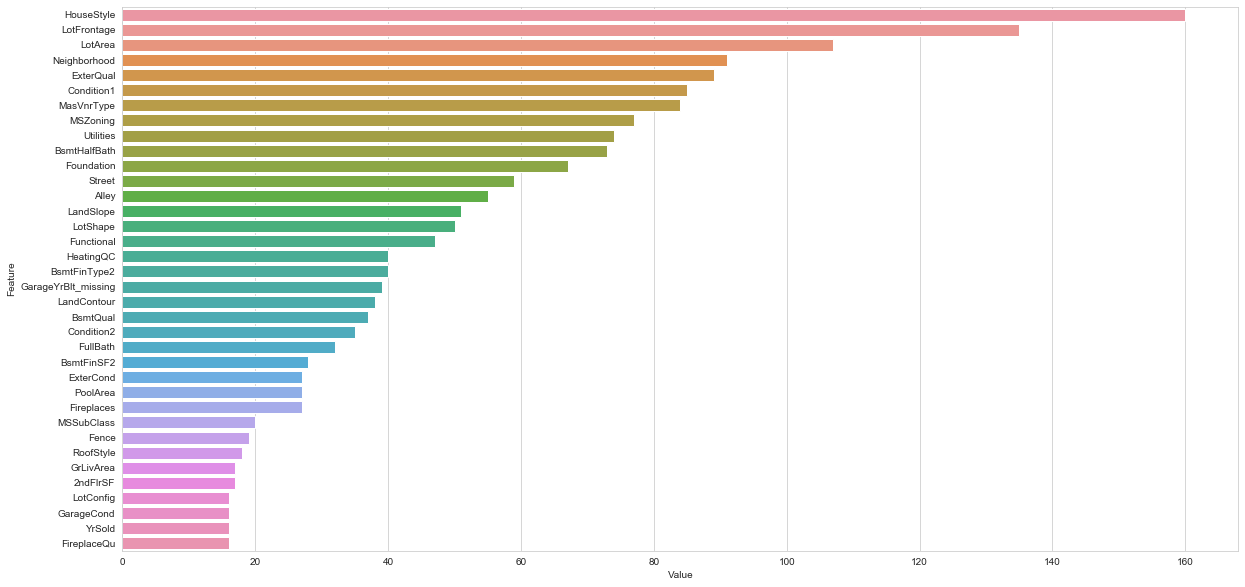

In [13]:
plt.figure(figsize=(20, 10))
sns.barplot(x='Value',
            y='Feature',
            data=feature_imp[feature_imp.Value > 15].
                    sort_values(by='Value', ascending=False)
           
           )

plt.show()

## Step 2 - Data Cleaning

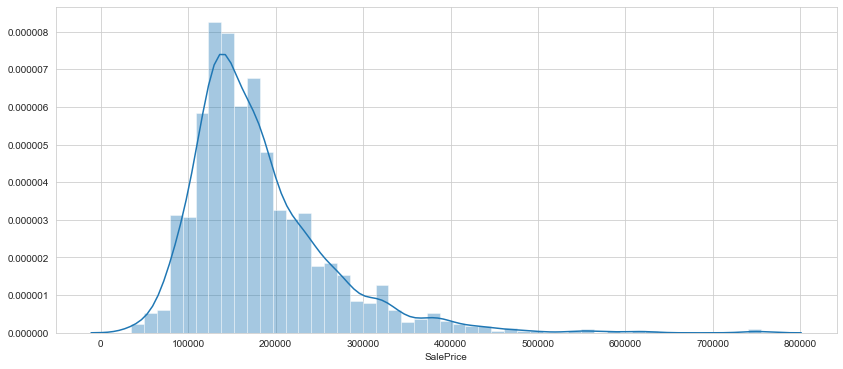

In [14]:
plt.figure(figsize=(14,6))
sns.distplot(a=df_raw.SalePrice)
plt.show()

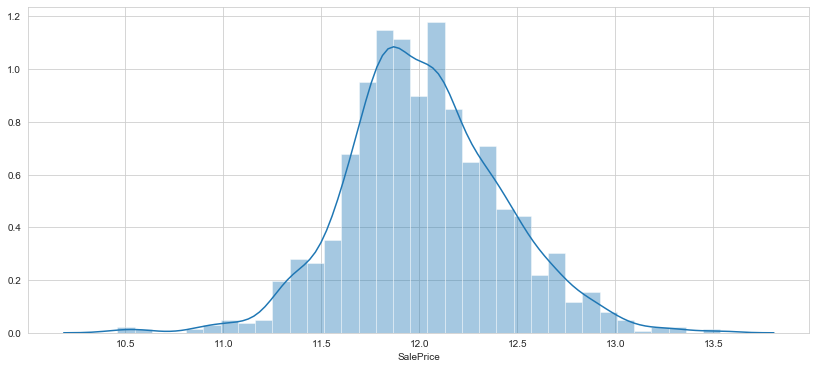

In [15]:
plt.figure(figsize=(14,6))
sns.distplot(a=np.log(df_raw.SalePrice))
plt.show()

It looks like the SalePrice follows aproximately a lognormal distribution and that there are no outliers, but let's compute the z-scores, maybe we find 1 or 2 candidates.

In [16]:
scores = pd.DataFrame(df_raw.SalePrice.copy())
scores['z_score'] = zscore(np.log(df_raw.SalePrice))
scores[scores.z_score > 3] #Usually the threshold is 3.5

,SalePrice,z_score
440,555000,3.011839
691,755000,3.782532
803,582933,3.134810
898,611657,3.255264
1046,556581,3.018962
1169,625000,3.309307
1182,745000,3.749141


The z-scores are not that high, but maybe there are other points with strange behaviours.

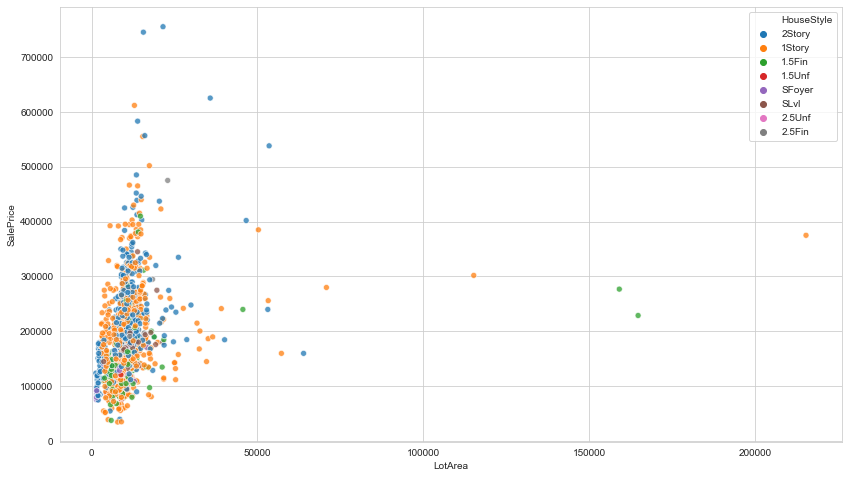

In [17]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='LotArea' , y='SalePrice', hue='HouseStyle', data=df_raw, alpha=0.75)
plt.show()

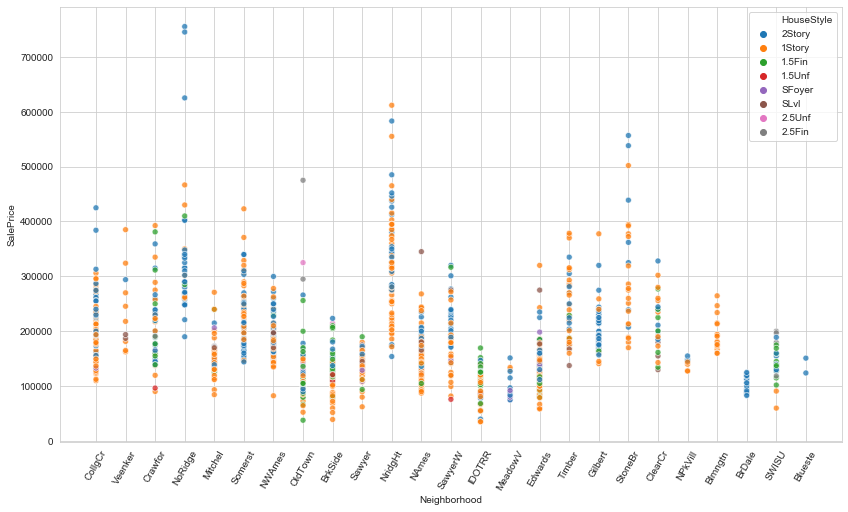

In [18]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='Neighborhood' , y='SalePrice', hue='HouseStyle', data=df_raw, alpha=0.75)
plt.xticks(rotation=60)
plt.show()

In the last figure we could observe that the two points with z-score > 3.5 are also quite distant from the mean of their neighbourhood, so let's drop them. Let's study also the distribution of the LotArea, which looks kinda weird.

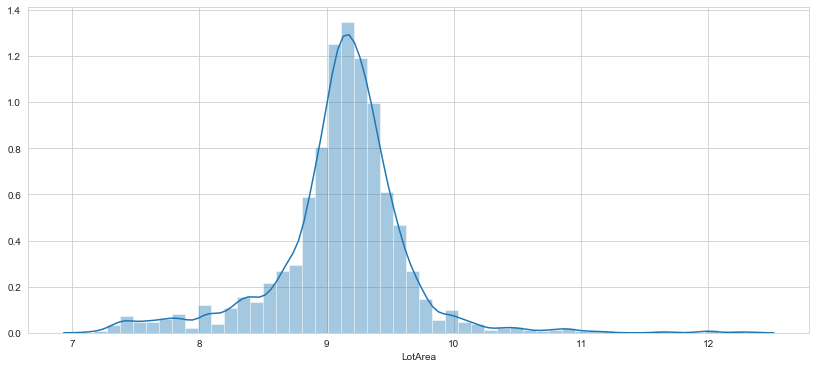

In [19]:
plt.figure(figsize=(14,6))
sns.distplot(a=np.log(df_raw.LotArea))
plt.show()

In [20]:
scores = pd.DataFrame(df_raw.LotArea.copy())
scores['z_score'] = zscore(np.log(df_raw.LotArea))
scores[scores.z_score > 3.5]

,LotArea,z_score
249,159000,5.540272
313,215245,6.125793
335,164660,5.607894
451,70761,3.975142
706,115149,4.916465
1298,63887,3.777582
1396,57200,3.563841


The distribution of the LotArea behaves as lognormal around the mean, but is a bit right-skewed. The points with area bigger than 100000 have very big z-scores, and we will also remove them.

The second most important feature for the model is the LotFrontage, which is the linear feet of street connected to property. Let's see if we can identify outliers, and also take a fast insight into the Foundation variable.

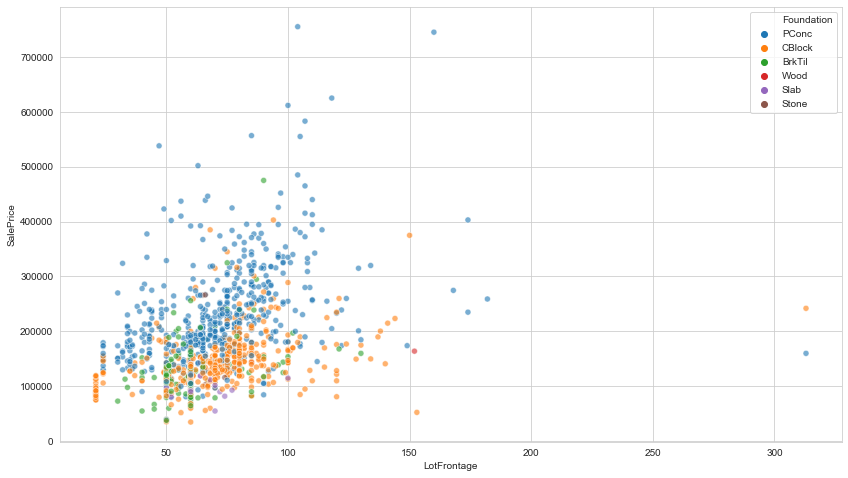

In [21]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='LotFrontage' , y='SalePrice', hue='Foundation', data=df_raw, alpha=0.6)
plt.show()

In [22]:
# Remove outliers

df = df_raw[df_raw.SalePrice < 700000].copy()
df = df[df.LotArea < 100000]
df = df[df.LotFrontage < 200]
df = df.reset_index(drop=True)

This were the main numerical variables. The rest are categorical. So let's start with the data pre-processing.

## Step 2.5 - More Data Cleaning

Let's start by finding which of the top features for our model have missing values.

In [24]:
top_features = list(feature_imp[feature_imp.Value > 10].Feature)
top_features.remove('GarageYrBlt_missing')   #This is generated in a further step
df[top_features].isnull().sum()[ df[top_features].isnull().sum() > 0] / df.shape[0]

BsmtExposure    0.026756
GarageQual      0.061873
MiscFeature     0.967391
FireplaceQu     0.501672
GarageCond      0.061873
Fence           0.810201
BsmtQual        0.025920
BsmtFinType2    0.026756
Alley           0.928094
MasVnrType      0.005017
dtype: float64

The objective of this part was to better impute the missing values if important features, but we got to a dead end, because fot the majority of them abscense of values means abscense of the specification, so the only we can do is to improve the quality of our labelling in our custom labeler. The upgraded columns are:
    
- Alley
- BsmtExposure
- Fence

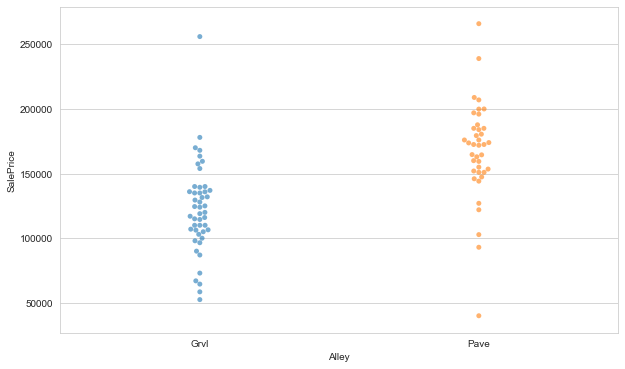

In [25]:
plt.figure(figsize=(10,6))
sns.swarmplot(x='Alley' , y='SalePrice', data=df, alpha=0.6)
plt.show()

Alley should be labeled with 2 for Pave, 1 for Grvl and 0 for NA.

The only conditions in which we could work a bit more are MasVnrArea and MasVnrType. They both lack values for the same rows, which indicates some consistency on the labeling, but on the description of our values no masonry is indicated with a MasVnrType = No, which might mean that simply they didn't get information about the masonry, not abscense of the masonry. But let's explore data a bit.

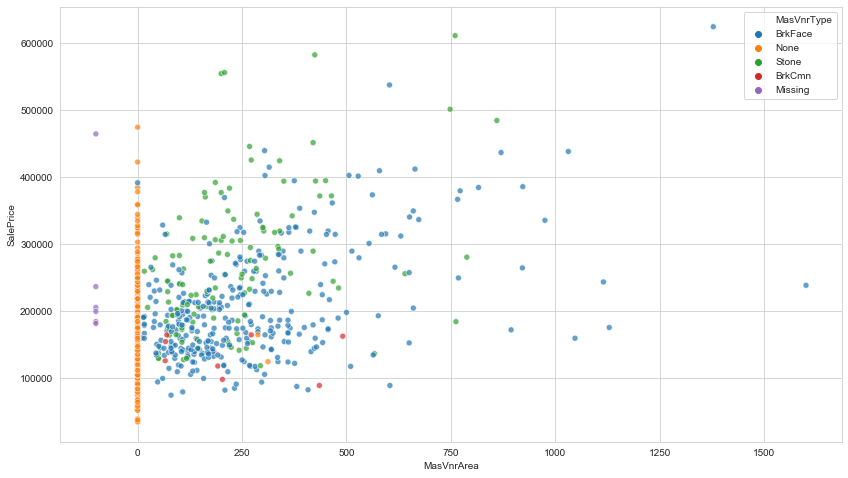

In [26]:
MasVnrArea = df.MasVnrArea.fillna(-100, inplace=False)
MasVnrType = df.MasVnrType.fillna('Missing', inplace=False)

plt.figure(figsize=(14,8))
sns.scatterplot(x=MasVnrArea, y='SalePrice', hue=MasVnrType, data=df, alpha=0.7)
plt.show()

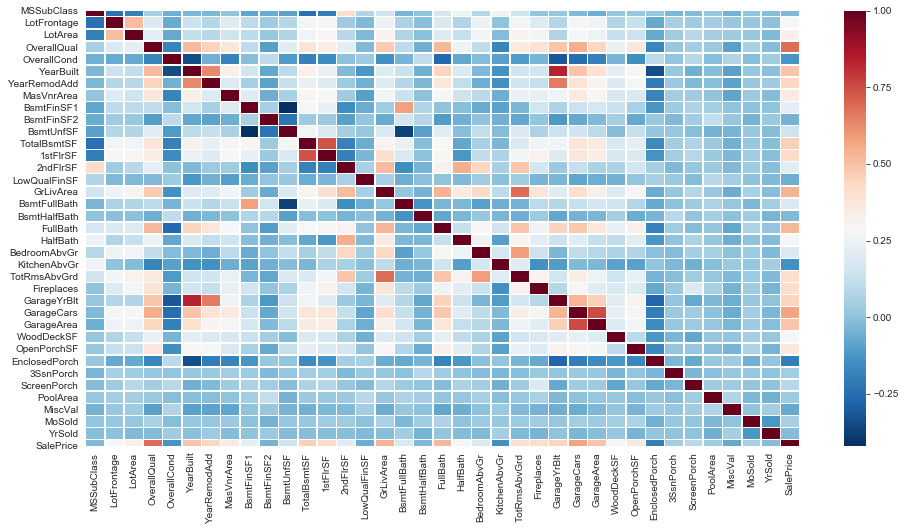

In [27]:
corr = df.corr(method='kendall')
plt.figure(figsize=(16, 8))
sns.heatmap( corr,
            xticklabels=corr.columns,
            yticklabels=corr.columns,
            cmap='RdBu_r',
            linewidth=0.5)
plt.show()

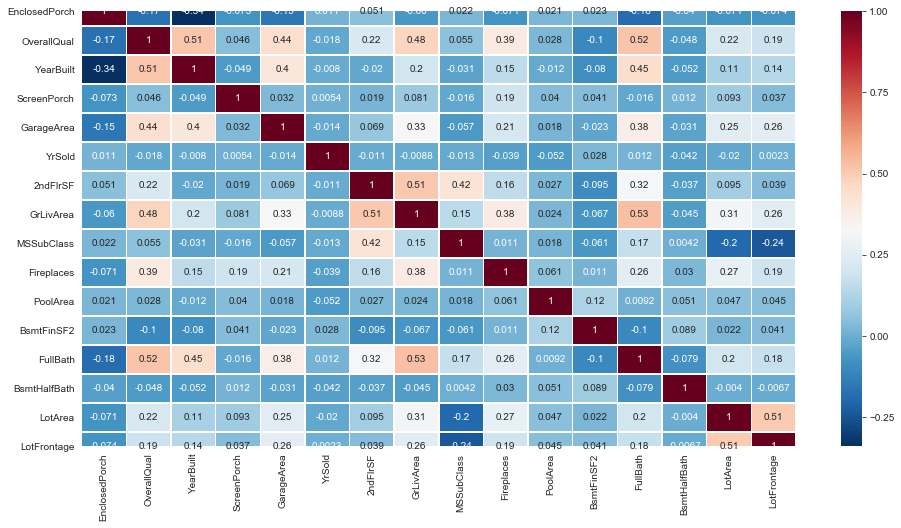

In [28]:
corr = df[top_features].corr(method='kendall')
plt.figure(figsize=(16, 8))
sns.heatmap( corr,
            xticklabels=corr.columns,
            yticklabels=corr.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)
plt.show()

As we can see in the the correlation matrix, MasVnrArea is highly related with OverallQual, so let's take a look at it to see if we can make some inferences about those missing values.

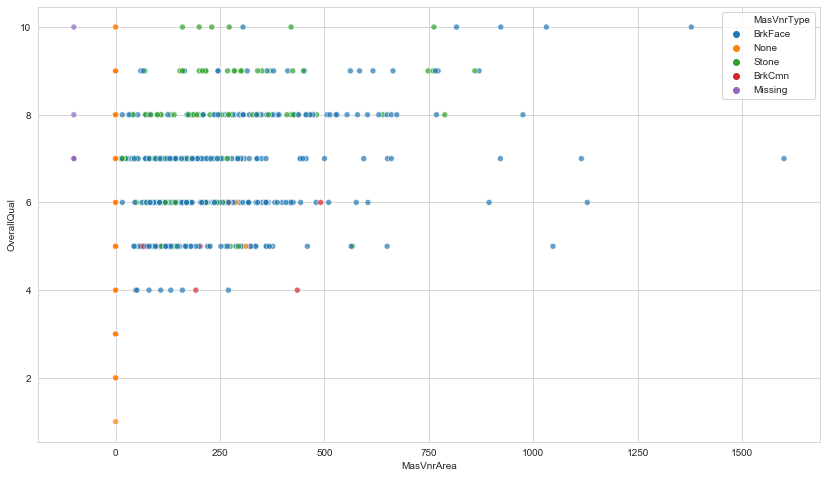

In [29]:
plt.figure(figsize=(14,8))
sns.scatterplot(x=MasVnrArea, y='OverallQual', hue=MasVnrType, data=df, alpha=0.7)
plt.show()

The houses without MasVnrArea specification have a good quality, so the method we used from the beggining of imputing missing values with the median of the columns should work well enough.

## Step3 - Final Model and Submission

In [30]:
# As we deleted some rows we should re-do this

num_vars = list(df_raw.columns[df_raw.dtypes != 'object'])
cat_vars = list(df_raw.columns[df_raw.dtypes == 'object'])

num_vars.remove(dep_var)

num_with_missing = list(df_raw.loc[:, num_vars].columns[
                            df_raw.loc[:, num_vars].isnull().sum() > 0
                        ])

In [31]:
X_test = pd.read_csv('test.csv')
X_test.drop('Id', axis=1, inplace=True)
X_test.MSZoning.astype('object')
for col in num_with_missing:
    X_test[col+'_missing'] = X_test[col].isnull()

In [32]:
best_pipeline.fit(X, y)

prediction = pd.DataFrame(np.exp(best_pipeline.predict(X_test)))

prediction = prediction.reset_index()
prediction.columns = ['Id', 'SalePrice']
prediction.Id += 1461

C:\Users\Ramon\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [33]:
prediction.to_csv('prediction.csv', index=False)

The score on Kaggle of the prediction was: 0.12827.

Which took me to the position 1673 out of 4751. That's the top 36%.

#### Let's take a look at the fitted data, and check everything is fine...

In [34]:
display_all(pd.DataFrame(preprocessor.transform(X), columns=X.columns).tail(20).T)

,1440,1441,1442,1443,1444,1445,1446,1447,1448,1449,1450,1451,1452,1453,1454,1455,1456,1457,1458,1459
MSSubClass,0.309859,1.492282,0.073375,-0.636078,-0.872563,0.664586,-0.872563,0.073375,-0.163109,2.911188,0.782828,-0.872563,2.911188,-0.872563,-0.872563,0.073375,-0.872563,0.309859,-0.872563,-0.872563
MSZoning,0.414907,-0.039223,0.687385,-0.039223,-0.311701,0.006190,-0.039223,0.460320,0.006190,-2.219047,-0.447940,0.369494,-1.583265,0.914450,-0.357114,-0.357114,0.687385,-0.175462,-0.084636,0.233255
LotFrontage,0.101141,-0.610435,0.048725,-0.166652,-0.202131,-0.212153,1.565986,-0.051798,0.125295,-0.900377,-0.152020,-0.125761,-0.685702,0.671505,-0.302353,-0.260560,0.266407,-0.147810,-0.080160,-0.058112
LotArea,-0.071836,-0.071836,2.821425,-0.071836,0.651479,-0.071836,-0.795151,1.374795,-1.518467,-0.795151,-0.795151,1.374795,-0.795151,-0.795151,0.651479,-0.071836,-0.071836,0.651479,-0.795151,-0.795151
Street,1.280685,-0.517200,-0.517200,0.381743,-0.517200,-0.517200,1.280685,-0.517200,1.280685,1.280685,-0.517200,-0.517200,-0.517200,-0.517200,-0.517200,-0.517200,0.381743,3.078570,0.381743,0.381743
Alley,-1.631786,1.084115,1.216598,-1.830511,1.084115,-0.174474,-0.306957,0.786028,-2.029235,-0.041991,0.090492,1.216598,1.117235,1.150356,1.084115,0.918511,0.222975,-1.002492,-0.704406,-0.207594
LotShape,0.442586,0.927122,1.120936,-1.689368,0.927122,-0.914112,-1.107926,0.539493,0.733308,-0.720298,-0.526484,1.169389,0.975575,1.024029,0.975575,0.733308,0.151865,1.024029,0.539493,-0.962566
LandContour,-0.570750,0.242890,0.314845,-0.570750,0.015957,-0.570750,0.475359,1.853567,-0.570750,-0.570750,-0.570750,0.503034,-0.127953,-0.570750,-0.570750,-0.570750,0.087911,-0.570750,-0.570750,-0.570750
Utilities,-0.973018,0.555685,0.704827,-0.973018,-0.973018,-0.562878,0.327586,1.393512,-0.973018,0.239856,-0.973018,-0.973018,0.226696,-0.973018,-0.073781,-0.973018,0.759659,-0.369871,-0.865548,0.847389
LotConfig,-0.288653,-0.288653,-0.288653,-0.288653,-0.288653,3.599381,-0.288653,-0.288653,-0.288653,-0.288653,-0.288653,-0.288653,-0.288653,-0.288653,-0.288653,-0.288653,0.722112,-0.288653,6.092188,1.509640
